In [1]:
from qiskit import *

In [2]:
import numpy as np
import matplotlib.pyplot as plt
#make my mplt plots with a white background instead of transparent since I'm using a dark theme#
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"} 

In [3]:
##load my IBMQ account stored on my Linux device - since I plan on accessing Qiskit Pulse
#compatible devices ##

from qiskit import IBMQ
IBMQ.load_account()

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

# I. Picking Qiskit Pulse Compatible Backends:

Not all backends support `Qiskit Pulse` so the following is a quick check whether the chosen backend offers Pulse-Level control features. We can also check the `Sampling Time`, which gives us the discrete time element resolution `dt` at which pulse channels and their waveform generators, on the specified backend, operate. 

`Backend configuration` contains realtime and formal IBM information regarding the specified backend, such as its name, qubit no. , basis gates etc....

In [4]:
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
real_backend = provider.get_backend('ibmq_armonk')

In [5]:
"""Since I wil be checking backend properties regularly I will define a function that
retieves some pre-specified info about a given backend"""
def tell_me_about_backend (backend):
    name = str(backend)
    backend_config = provider.get_backend(name).configuration()
    print("the backend basis gates are " , backend_config.basis_gates)
    print("the backend name is " , backend_config.backend_name, "version ",
          backend_config.backend_version, "operating", backend_config.n_qubits,"qubit(s)")
    assert backend_config.open_pulse,"Backend doesn't support Pulse"
    print("Qiskit Pulse is supported on", backend_config.backend_name ,"and we are ready to go")
    dt = backend_config.dt
    print(f"Discrete Sampling Time Element for this machine is: dt= {dt*1e9} ns") 

In [6]:
tell_me_about_backend('ibmq_armonk')

the backend basis gates are  ['id', 'rz', 'sx', 'x']
the backend name is  ibmq_armonk version  2.4.22 operating 1 qubit(s)
Qiskit Pulse is supported on ibmq_armonk and we are ready to go
Discrete Sampling Time Element for this machine is: dt= 0.2222222222222222 ns


Since I will be running some simulations first to test drive Qiskit Pulse, I can, for the time being, instead use one of the compatible `mock backends`, specifically the `"FakeValencia"` backend for these purposes, which would give me reasonable test results comparable to current IBM machines.

In [7]:
## first we import our virtual backend and define it as `fake_backend`
from qiskit.test.mock import FakeArmonk
from qiskit.test.mock import FakeValencia ## I'll use FakeValencia for most of this test
fake_backend_1 = FakeValencia()

# II. What we need to know about our Pulse:

We can now import Qiskit Pulse and use it to setup some arbitrary pulses with both predefined parametric waveforms in the `pulse.library`, mostly notably Gaussians, or we can explicitly set up our own array of `discrete sample points` for a wave envelope; with the latter requiring more overhead. As per Qiskit's documentation and in the two most notable IBM team lead Qiskit pulse papers, there are 3 main components to pulse level control `Pulse Shapes/Waveforms`, `Pulse channles` and `Pulse Schedules`:

#### 

## A. Pulse Shapes (Parametrized Pulses or Sampled Waveforms): 
These usally define the `shape` of the wave envelope and there are different ways users can specify these shapes. The most common shape functions provided by the `pulse.library` are: 
#### 
#### A.1. Parametrized Pulses
A.1.1. `Gaussians` - with parameters ( duration or "Pulse length" in terms of discrete dt units, amplitude, deviation $\sigma$, ), display name for this pulse envelope).  
A.1.2. `Gaussian Squares` - Square pulse with a Gaussian shaped risefall on both sides - Parameters same as Gussians but with an extra reference to either risefall_sigma_ratio or width.  
A.1.3. `DRAG Pulses` - The Derivative Removal by Adiabatic Gate (DRAG) pulse similar to a Gaussian pulse but with an additional corrective derivative $\beta$.  
A.1.4. `Constant Pulses` - a constant Amplitude pulse for a given dt-units in duration with - paramterised amplitude and duration.  
A.1.5. `Discrete Pulses` - Sines, Cosines, squares, triangles, Sawtooth etc ...  
#### 
#### A. 2. Sampled Waveforms
A.2.1. `Sampled Waveforms` - arbitrary waveform corresponding to an array of time-ordered samples/Complex amplitudes.

#### 
NB: Pulse parameters `frequency` and `phase` are specified for every pulse channel and need target/qubit specific calibration (unlike generic/stock gate pulses). These parameters can be accessed through the channel commands/instructions below.
####  
## B. Transmit and Receive Channels and Pulse Instructions:
Channels are communication lines that are specified as either a `Transmit`/`PulseChannel` or `receive`/`acquire` channels, and accordingly channels carry instructions to and from hardware. The channels are labeled as per their target qubit ($q_i$), since as we mentioned above, they are target specific and are calibrated to work with a specific target qubit and cannot be reallocated to a different qubit without recalibration. Pulse channels have a user specifiable frequency $f$ and phase $\phi$, among other channel instructions mentioned below. The channels a user can control are:  
#### B.1. Pulse Channels  
B.1.1. `DriveChannel` $(d_i)$ - signals driving pulses in resonance with $q_i$  
B.1.2. `ControlChannel` $(u_i)$ - signals pulses enacting other interaction terms in the Hamiltonian  
B.1.3. `MeasureChannel` $(m_i)$ - signals the readout component on $q_i$
#### B.2. AcquireChannel
Runs in unison with the MeasureChannel but is a receive only channel that acquires and digitizes data from the readout component of $q_i$.  

## C. Pulse Schedule:

Similar to how we build a QuantumCircuit to start accessing our circuit specific functions, channels and scheduling commands need their own `pulse.schedule` object to initiate the pulse building assembly line. This can be done through a `pulse.schedule` object, or by utilizing an easier, but less maneuverable, option through the  `pulse.build` command. After initializing a schedule, pulse commands can be given through `pulse insructions`, offering the user full reign over what pulse a channel should play, how long it should be Playing or Idling, what frequency and phase should that channel be sending pulses at, and signaling the acquisition of readout data on that channel when it is ready for mesurement. These schedule commands are self explanatory and include:  
C.1. `Play`  
C.2. `Delay`  
C.3. `ShiftPhase`  
C.4. `SetFrequency`  
C.5. `Acquire`  

#### 

In the following code I will utilize all these Pulse Controls options to showcase a typical Pulse Control workflow.

# III. Building our First Pulses and Pulse schedule:


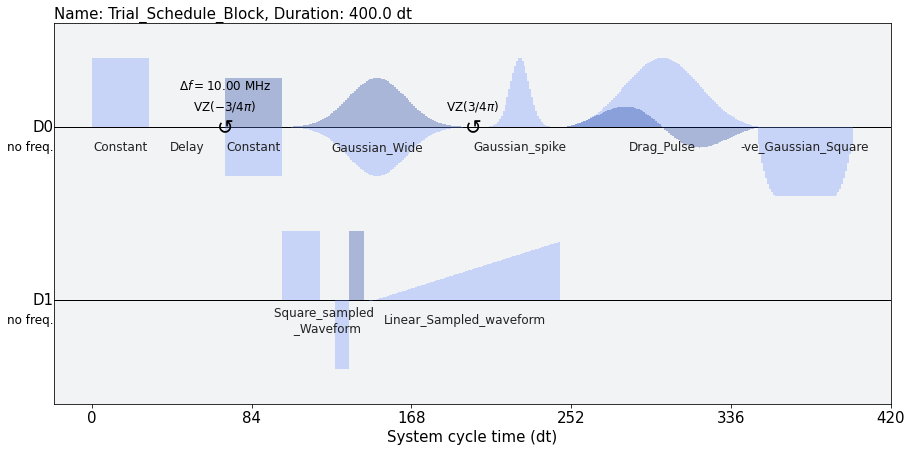

In [8]:
## Using pulse.build()function and giving it a backend as its argument

with pulse.build(fake_backend_1,name='Trial_Schedule_Block') as my_drive_sched: 
    
    d0 = pulse.drive_channel(0) ## setup qubit 0's driving channel
    d1 = pulse.drive_channel(1) ## setup qubit 1's driving channel
    c0 = pulse.control_channels(0,1)
    a0 = pulse.acquire_channel(0) ## setup qubit 0's acquire channel for readout
    a1 = pulse.acquire_channel(1) ## setup qubit 1's acquire channel for readout
    
    'Trying out different pulse waveforms and instrusctions:'
    
    ## building our first pulse envelopes :
    pulse_1 = pulse.library.Constant(30, 1) #constant with duration 10dt and 2-norm amplitude 1
    # Next, a Gaussian with 100dt width, 2-norm amplitude of 1 and a standard deviation of 15.
    pulse_2 = pulse.library.Gaussian(100, 1.0, 15.0,name= 'Gaussian_Wide') 
    pulse_3 = pulse.library.Drag(100, 1.0, 20.0,10,name='Drag_Pulse') 
    pulse_4 = pulse.library.GaussianSquare(50,-1.0,20, 
            risefall_sigma_ratio=0.5, name='-ve_Gaussian_Square')
    
    
    ## give the pulse specific and scheduling commands
    'NB: these pulse commands will be issued in order and accumulatively'
    pulse.play(pulse_1 , d0) ## play pulse_1, the constant pulse on the channel d0.
    pulse.delay(40, d0) ## add a 20 dt delay on channel d0 following pulse_1.
    
    'Now to test the effects of changing the phase of a channel'
    
    pulse.shift_phase(3*np.pi/4, d0) ## initiate a phase shift by a factor of $exp(-3pi/4)$
    
    pulse.shift_frequency(1e7, d0) ## initiate a frequency shift in the channel
    
    pulse.play(pulse_1 , d0) ## replay pulse_1 to see the effect of the phase change in the channel
    
    "This shows that we can append extra pulse commands to the current schedule"
    with pulse.build() as append_sched:
        pulse.play(pulse_2, d0)
        
        ''' we revert back to no phase by setting it to zero, the scheduler automatically
        calculates the required shift to achieve a zero phase, which was +3pi/4, as
        we can see above the circular arrow: '''
        
        pulse.set_phase(0, d0) 
               
        ## we can also specify the pulse shape directly into the argument like below
        pulse.play(pulse.library.Gaussian(50, 1.0, 5.0,name= 'Gaussian_spike'), d0)
        pulse.play(pulse_3, d0)
        pulse.play(pulse_4, d0)
        
        '''now to include a second channel d1 and this time we will use a 
        sampling to shape our wavefront with an array of complex amplitudes'''
        
        square_array = np.array([1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,
                    0, 0, 0, 0, 0, 0, 0, 0, -1, -1,-1,-1,-1,-1,-1, 
                    0+1j, 0+1j, 0+1j, 0+1j, 0+1j, 0+1j, 0+1j, 0+1j, 
                    0, 0, 0]) ## this is an array of square waves
        pulse_5 = pulse.library.Waveform(square_array,name='Square_sampled \n _Waveform')
        pulse.play(pulse_5,d1)
        ## this is a line with a slope, we just set a line equation with some slope between
        # 168dt and 468 dt and take 100 samples along the line for our waveform##
        spacing= np.linspace(168,468,100)
        pulse_6 = pulse.library.Waveform(1/350*spacing-0.5,name='Linear_Sampled_waveform')
        pulse.play(pulse_6,d1)
        
        '''If we want to exceed the unit amplitude we can alter the setting limit_amplitude'''

    pulse.call(append_sched) ## To append the extra schedule we must use pulse.call 
    #pulse.acquire(500, a1, pulse.MemorySlot(0))
   # pulse.measure(qubits=[0], registers=[pulse.MemorySlot(0)])

''' Now to draw our schedule which uses the matplotlib plotter here
we can always adjust the figure size using matplotlib functions'''

fig2, ax2 = plt.subplots(figsize=(15, 7)) ## resize the plot using matplotlib functions
## use the shedule draw command and inform it of the matplotlib axis above
my_drive_sched.draw(show_waveform_info = True,axis =ax2)




### Some Important Notes on Pulse commands and Pulse Channel Phase Changes:

Note that at the very beginning we started off with no phase, and so the no phase wave envelope was Light Colored, as opposed to later on after phase changes. 

There are two `ways to enact phase change on a channel`, we either specify a pulse shift through `pulse.shift_phase`, which shifts the current phase of the channel by the specified angle, OR we specify a final phase for the channel through `pulse.set_phase`, where the pulse instruction automatically determines how much a channel needs to shift to get to the new phase and adds that change to the labels accordingly. It must be emphasized that the `schedule or build.draw` illustration adds a small arrow whenever there is either a frequency shift $\Delta f$ (like the 10MHZ shift here) or phase shift $VZ$, and the value next to the arrow is the `parameter change` and not the final value.  
It is important to emphasize that after a phase change in the channel the amplitude is probably no longer purely real, and we get an imaginary amplitude contribution, making it an overall complex amplitude instead. The `imaginary Amplitude` is seen as a `Dark colored imaginary wave envelope`, in this case dark blue. We can see that color and amplitude divide in the wave envelope after our first $e^{-i3\pi/4}$ phase shift. This shift should give us a `real amplitude of -0.707` and an `imaginary amplitude of +0.707`, which combined, still preserves the unitary 2-norm amplitude. Accordingly, after running pulse_1 again, we notice that the purely real unit amplitude of the first pulse_1 in the schedule had shifted into an equal amplitude +ve `Dark Complex Wave Envelope` and negative `bright Real Wave Envelope`.  
Finally, we note that the phase of the channel carries over to the next Wide Gaussian pulse, and reverts after our phase change before the final Spike Gaussian; this behavior is what we mean by accumulative nature of the channel.  



# IV. Side by Side comparison of Bell State prep using standard Stock gate sets vs Pulse Level Calibration and Preparation

`Work In Progress I only did the first half still need to figure out how to optimize the gate prep`

In [9]:
from qiskit.test.mock import FakeAlmaden
fake_backend_2 = FakeAlmaden()
backend_config_2 = fake_backend_2.configuration();
print("the backend basis gates are " , backend_config_2.basis_gates)
print("the backend name is " , backend_config_2.backend_name, "version ",backend_config_2.backend_version
     , "operating", backend_config_2.n_qubits,"qubit(s)")
assert backend_config_2.open_pulse,"Backend doesn't support Pulse"
print("Qiskit Pulse is supported on", backend_config_2.backend_name ,"and we are ready to go")
dt = backend_config_2.dt
print(f"Discrete Sampling Time Element for this machine is: dt= {dt*1e9} ns") 

the backend basis gates are  ['id', 'u1', 'u2', 'u3', 'cx']
the backend name is  fake_almaden version  1.4.6 operating 20 qubit(s)
Qiskit Pulse is supported on fake_almaden and we are ready to go
Discrete Sampling Time Element for this machine is: dt= 0.2222222222222222 ns


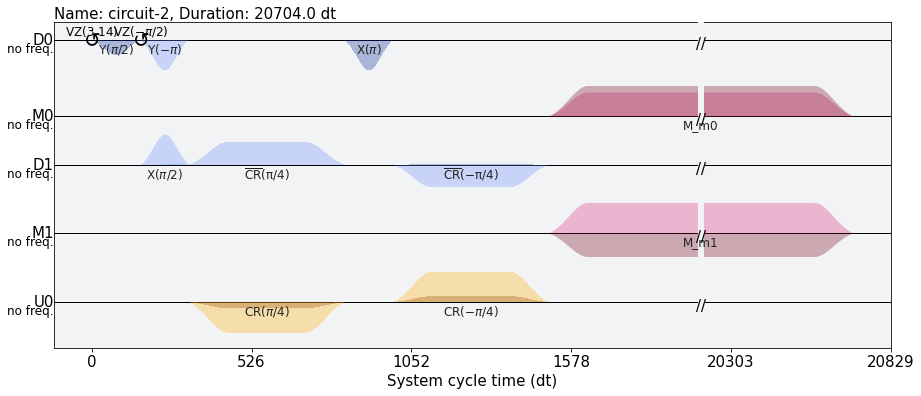

In [10]:
from qiskit import QuantumCircuit, transpile, schedule

qc = QuantumCircuit(2, 2)
qc.h(0)

qc.cx(0, 1)
qc.measure(0, 0)
qc.measure(1,1)
qc = transpile(qc, fake_backend_2)
pulse_schedule = schedule(qc, fake_backend_2)
'''## since the Almaden machine has 20 qubits and we are 
only using 2 we add the idle_wires-false command to draw to avoind clutter'''
fig2, ax2 = plt.subplots(figsize=(15, 6))
pulse_schedule.draw(axis=ax2)


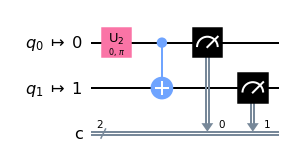

In [11]:
qc.draw('mpl',idle_wires=False)


This Pulse Schedule is what the above circuit would translate to in terms of basis gates using the circuit model. My goal is to show how this process of creating a bell state can be optimized by using pulse level commands, `(maybe first by hand then look for an automated approach/Optimizers ??)`. I will return to this section later.

In [12]:
'''adding some aesthetic options to the page'''

## these 2 lines justify markdwon cells
from IPython.core.display import display, HTML
display(HTML("<style>.text_cell_render p {text-align: justify; text-justify: inter-word;  }</style>"))

## this line enlarges the width of all cells
display(HTML("<style>.container { width:70% !important; }</style>"))

# V. Using pulse level control to calibrate the frequency of our single qubit 

This calibrated frequency will later be use in our `qubit[0] specific calibration of a Pi pulse` which is done using a series of Rabi experiments, and whose workflow follows that of the frequency sweep as they both depend on pulse-level control.

This is a trial run of the Qiskit tutorial experiment in their notebook and so closely follows the qiskit tutorial with ocassional small modifications but also a ton of my own commentary and explanation, especially within the code itself. The tutorial can be found under :
[Investigating Quantum Hardware Using Microwave Pulses](https://qiskit.org/textbook/ch-quantum-hardware/calibrating-qubits-pulse.html)


This sequence of rabi experiments for pi-pulse calibration will take place on a real backend, the one we started off this work with `ibmq_armonk`. We ahave already specified its most important characteristics and assigned the machine the name `real_backend`, but I will repeat them here again for convenience.

In [13]:
tell_me_about_backend(real_backend) ## this is the function we defined earlier to tell us abt backends

the backend basis gates are  ['id', 'rz', 'sx', 'x']
the backend name is  ibmq_armonk version  2.4.22 operating 1 qubit(s)
Qiskit Pulse is supported on ibmq_armonk and we are ready to go
Discrete Sampling Time Element for this machine is: dt= 0.2222222222222222 ns


### V.i. Finding our single qubit Frequency using a Frequency Sweep

The machine already has a good default range for its frequencies that we could use as our starting point for our sweep. We can assign these to `real_backend_default`

In [14]:
real_backend_defaults = real_backend.defaults()

We can use the command `qubit_freq_est` to extract an estimate of the machine qubit frequencies stored in its `defaults` backend object. This way, we can `center our frequency sweep` around this estimate, reducing our search overhead immensely.   

However, an important thing to note is that the backend characteristics and stored properties are all expressed in SI units, so it would be wise to scale up the frequency orders to within `Gigahertz` and similarly, scale down the seconds to `nanoseconds`, that way we can work on a scale appropriate for superconducting transmon pulse regime.

In [15]:
'''Unit conversions'''

ns = 1.0e-9 # time in Nanoseconds
GHz = 1.0e9 # frequency in Gigahertz

'''Specifyng our target qubit channel and memmory channels, 
this should be easy here since we have a single qubit in the machine'''
qubit = 0
memory_slot = 0

'''Determining the center of our sweep: '''
center_Hz = real_backend_defaults.qubit_freq_est[qubit] 

print("the backend" , real_backend.configuration().backend_name,
      "has an estimated qubit frequency of around ", center_Hz/GHz,"GHz.")

'''NB: I tried running this experiment with a different sweep radius and different center
but it returned an error on running the job, so there it is probably a good Idea to check
the default frequency of the machine on the respective qubit we will
be calibrating the pulse channel for and stick to the recommended range of 20 MHz radius sweep 
until I wrap my head around why a channge to 100 MHz returned an error.'''

# Our sweep will have a radius of 0.02GHz around the default qubit backend frequency
span_Hz = 0.04 * GHz
# in steps of 1 MHz.
steps_Hz = 0.001 * GHz

frequency_min = center_Hz - span_Hz / 2
frequency_max = center_Hz + span_Hz / 2

'''Now to sample this range and store the samples in an array for use in our experiment'''
frequencies_GHz = np.arange(frequency_min / GHz, 
                            frequency_max / GHz, 
                           steps_Hz / GHz)

print(f"The sweep will go from {frequency_min / GHz} GHz to {frequency_max / GHz} GHz \
in steps of {steps_Hz / GHz} GHz.")

the backend ibmq_armonk has an estimated qubit frequency of around  4.9715892377847215 GHz.
The sweep will go from 4.951589237784721 GHz to 4.991589237784721 GHz in steps of 0.001 GHz.


In [16]:
print("The frequency array has", frequencies_GHz.shape[0], "samples")

The frequency array has 41 samples


### V.ii. This is where we use the skills we learnt during the initial pulse trials. We need to create a pulse schedule and set up our pulse parameters, our pulse instructions for  driving channel and measurment channel for the calibration experiment.

NB: Given the frequency array we have established spanning the sweeping radius, we will initiate the sweep by sending a corresponding `drive pulse matching each frequency` to the qubit and have the measure channel ready for immediate readout after each the pulse. That way we gather all the info on the qubit response to every individual pulse frequency and we can go for a best fit analysis. Our Pulse shape is a Guassian so we should be familiar with the parameters.

In [17]:
"""The calibration tutorial specifies 16dt wide increments 'or rather 16 Samples wide'
increments for setting up discrete time durations, so we will stick to that.
This will be used to set the pulse play durations in terms of dt eventually by a
transforming function 'pulse.seconds_to_samples'
"""
def get_closest_multiple_of_16(num):
    return int(num + 8 ) - (int(num + 8 ) % 16)

## turning frequency into a parameter to use it as an input variable later during our sweep
from qiskit.circuit import Parameter  


drive_sigma_sec = 75 * ns ## deviation in units of ns
'''This is reasonable given our backend has a time sample resolution of dt= 0.2222222222222222 ns''' 
drive_duration_sec = drive_sigma_sec * 8 ## duration that the gaussian is played 
'''We specified above 8* the standard deviation sigma for the gaussian as our cutoff for duration'''
drive_amp = 0.05 ## half a unit of purely real amplitude for the gaussian envelope


'''Now for our scheduling pulse instructions and channel setup'''
freq = Parameter('freq') ## this is the parameter we wanted to keep track of, the frequency param

'''Now to setup the pulse schedule using our previoulsy introduced build command'''
with pulse.build(backend=real_backend, default_alignment='sequential', 
                 name='Frequency sweep') as sweep_schedule:
    
    drive_duration = get_closest_multiple_of_16(pulse.seconds_to_samples(drive_duration_sec))
    '''This first turns the given drive duration into sample or dt units, 
    then rounds to the nearest 16 of them, in the end, the argument is always
    representing time in dt time increments'''
    drive_sigma = pulse.seconds_to_samples(drive_sigma_sec)
    drive_chan = pulse.drive_channel(qubit) ## specifcying the drive channel on qubit 0
    pulse.set_frequency(freq, drive_chan) ## setting initial channel frequency from our freq parameter
    # Setting up our Guassian pulse parameters with a duration of around 16 dt
    pulse.play(pulse.Gaussian(duration=drive_duration,
                              sigma=drive_sigma,
                              amp=drive_amp,
                              name='freq_sweep_excitation_pulse'), drive_chan)
    # Setting up our measurement pulse channel and readout schedule
    pulse.measure(qubits=[qubit], registers=[pulse.MemorySlot(memory_slot)])
        

'''Finally, creating the frequency settings for the sweep (MUST BE IN HZ)'''
frequencies_Hz = frequencies_GHz*GHz ## turning our frequency array, which was in GHz to HZ

######################################## IMPORTANT STEP #######################################
'''Now to just rerun the experiment with the next frequency in the list (care it needs to be in HZ
so use the frequencies_Hz not the frequencies_GHz) by replacing the current
channel's frequency parameter by the next frewuency down the list'''
schedules = [sweep_schedule.assign_parameters({freq: f}, inplace=False) for f in frequencies_Hz]


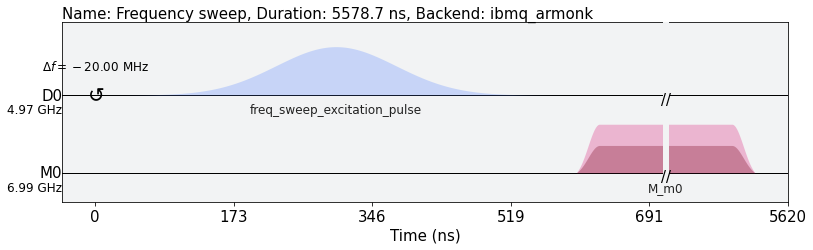

In [18]:
schedules[0].draw(backend=real_backend) 
## there are 99 members of this frequency array and this is the first one, hence schedules[0]

In [19]:
num_shots_per_frequency = 1024

job = real_backend.run(schedules, 
                  meas_level=1, 
                  meas_return='avg', 
                  shots=num_shots_per_frequency)
from qiskit.tools.monitor import job_monitor
job_monitor(job)

Job Status: job has successfully run


`NB: I tried running this experiment with a different sweep radius and different center and it broke down, so there it is probably a good Idea to check the default frequency of the machine on the respective qubit we will be calibrating the pulse channel for and stick to the recommended range of 40 MHz radius sweep until I wrap my head around why a channge to 100 MHz returned an error.`

In [20]:
frequency_sweep_results = job.result(timeout=120) 
# timeout parameter set to 120 seconds wait for a job

### V.iii: Plotting and fitting the Lorentzian Measured Signal from the frequency sweep

We expect the measured signals to readout a `Lorentzian`, so I will prepare the `Scipi.optimize` function `curve_fit` accordingly. It is important that we know how to customize our fit since the results will vary from that of the tutorial and require case-by case fitting. One should also note that the measured signal here will peak at a minimum and so the lorentzian will be upside down; I will account for that by adding a `negative scale factor` to the results.

#### V.iii.a: Peparing the sweep results for plotting and fitting 

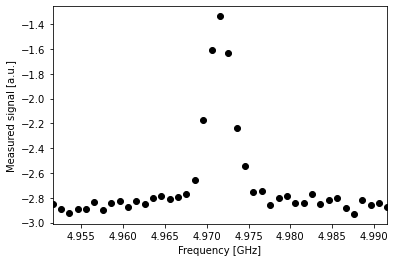

In [21]:
'''We will now create an empty array and store our sweep results in there for later plotting'''
sweep_values = [] ## our empty array to store signal readouts from the sweep at every frequency run

scale_factor = -1e-14 
## I added a negative since this Loretzian is inverted so I want to flip it back on its head
'''This factor adjusts the units for the results 
#so that they are plottble to within an order of magnitude of arbitrary units ''' 


'''This is how we access the readout as per the tutorial, 
the function is as it was used in the tutorial'''
## we first access every run and iterate down the results list length while recording
#the corresponding signal readout but not before scaling it##
for i in range(len(frequency_sweep_results.results)):
    ## Get the results from the ith experiment which ran at 
    #the ith frequency in the frequencies_GHz list##
    res = frequency_sweep_results.get_memory(i)*scale_factor
    ## access the results for the qubit number `qubit` from this experiment, 
    #in this case its only qubit 0 since we are running a single qubit experiment##
    sweep_values.append(res[qubit])

plt.scatter(frequencies_GHz, np.real(sweep_values), color='black') # a scatter plot of sweep values
plt.xlim([min(frequencies_GHz), max(frequencies_GHz)]) ## setting up the x-values range
## labelling the axes accordingly
plt.xlabel("Frequency [GHz]")
plt.ylabel("Measured signal [a.u.]")
plt.show()

#### V.iii.b: Using Scipi Optimization function to find the best fit for the sweep results vs freq plot

In [22]:
from scipy.optimize import curve_fit ## importing the curve_fit function from scipi.optimize module

'''The fit function we defined will take inputs:
x-values -  for the plot,

y-values - for the plot,

function - a general function that would closely mimic the measured signal - we already discussed how
Lorentzians offer a great fit for signals in the context of these kinds of pulse experiments

initial parameters - a "guess" as to what a good starting point for the function parameters might
be for the fitting process.

Finally the function returns the y-values of the fitted curve and the new parameters for the fit
which would replace our guess parameters
'''
def fit_function(x_values, y_values, function, init_params):
    fitparams, conv = curve_fit(function, x_values, y_values, init_params)
    y_fit = function(x_values, *fitparams)
    
    return fitparams, y_fit

In [23]:
'''We now run the fit function using 
frequencies in GHz as x-vales
real values of the measured signal as the y-values
the Lorentzian as our function, to do that we specify a 
python "lamda" anonymous function with the lorentzian parameters:
x - the x indep variable in a lorenztian equation ,
A - the normalization, so if A=5 then the lorentzian will not be normalized rather scaled to 5
qubit_freq - the center of the Lorentzian this corresponds to
the qubit frequency(in GHz) at the center of the sweep which we will get from
center_Hz but then scale it to GHz
B - width of the Lorentzian which is the Gamma in the Lorentzian equation;the max value at the peak
should be 2/(pi*gamma) so we can get an approximate of this
C - The vertical shift, in this cse -2.8

NB: we used the lambda ....... function to set up the Lorentzian an anonymous function given by 
our Lorentzian equation
'''
fit_params, y_fit = fit_function(frequencies_GHz,
                                 np.real(sweep_values), 
                                 lambda x, A, q_freq, B, C: 
                                 (A / np.pi) * (B / ((x - q_freq)**2 + B**2)) + C,
                                 [5, center_Hz/GHz, 1, -2.8] # initial parameters for curve_fit
                                 ## notice we used center_Hz/GHz for the center of our Lorentzian
                                )

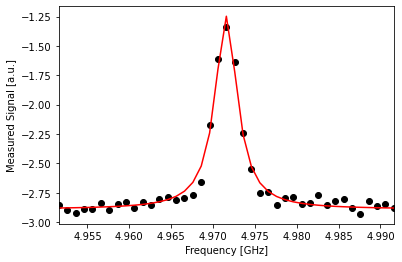

In [24]:
"Now we just plot everything"

## the scatter plot with the frequencies in GHz in the x and real values of the signals on the y-axis
plt.scatter(frequencies_GHz, np.real(sweep_values), color='black') 
## now plot the fitted line form y_fit as the y and frequencies again as the x
plt.plot(frequencies_GHz, y_fit, color='red')
## determin x range.
plt.xlim([min(frequencies_GHz), max(frequencies_GHz)])
## label everything
plt.xlabel("Frequency [GHz]")
plt.ylabel("Measured Signal [a.u.]")
## show all plots in one
plt.show()

#### V.iV: Updating our qubit frequency before the rabi experiment

We can clearly see our 41 data points for the frequency sweep, and a clear resonant frequency for the qubit corresponding to the peak signal. Its now time to record our new `updated frequency for qubit[0]`, the frequency we will calibrate our pulse to for our upcoming `rabi experiment`.

In [25]:
A, rough_qubit_frequency, B, C = fit_params
rough_qubit_frequency = rough_qubit_frequency*GHz # the qubit freqa must be in HZ so scale up
print(f"We've updated our qubit frequency estimate from "
      f"{round(real_backend_defaults.qubit_freq_est[qubit] / GHz, 7)} GHz to {round(rough_qubit_frequency/GHz, 7)} GHz.")

We've updated our qubit frequency estimate from 4.9715892 GHz to 4.9715717 GHz.


# VI. Using the updated frequency from the frequency sweep on Qubit[0] to calibrate our pi pulse using the Rabi Experiment for an amplitude sweep.

Through the frequency sweep, we were able to identify the optimal frequency over which our channels can interact with qubit[0]. We can now use this frequency to run further pulse calibrations for future pulse channels. This time we want to calibrate a specific signal pulse, the $\pi$ pulse on qubit[0]. The $\pi$ Pulse is basically the equivalent of an $X$-gate.

We have already identified the driving microwave frequency for qubit[0] on the `ibmq_armonc` machine, but now we need to calibrate another pulse parameter the `amplitude` for a $\pi$ pulse, that would correspond to an actual operation, the `bit-flip` operation, so this pulse can drive qubit[0] from the $0$ to the $1$ state and vice versa. 

To calibrate this pulse for qubit[0], we need to optimize the `amplitude of the pulse` we will be running on this specific pulse `drive channel`. To do that we will just sweep through the default backend range of amplitudes in small increments, measuring qubit[0]'s correspnding state each time.  

This back and forth oscillation between the ground state and the first excited state of a 2-state system is called the `Rabi oscillation`, and it is the phenomenon behind what we know as the `Rabi experiment`, an experiment that is commonly used by providers in calibrating their individual qubits on a specific machine. Similarly, we here want to calibrate qubit[0] for a `bit-flip` transition in state, which can be optimized by a calibrated $\pi$ pulse.

#### VI.i. Setting up the series of pulse schedules for the Pi-Pulse Amplitude sweep

In [26]:
'''We start by specifying the resolution of our increments, 
so we will define an amplitude range and how many increments we want in that range '''
## this is how the experiment ws set up in the tutorial :

num_rabi_points = 50
drive_amp_min = 0
drive_amp_max = 0.75
## a list of 50 amplitudes evenly spaced from 0 to 0.75
drive_amps = np.linspace(drive_amp_min, drive_amp_max, num_rabi_points) 

Next we set up our sequential Rabi-experiments for the sweep, increasing the amplitude from 0 towards 0.75 in equally spaced 50 increments, this test is set up using basically the same schedule we used for the frequency sweep, it is still a Gaussian driving pulse, same parameters except for the calibrated driving channel frequency :

In [27]:

drive_amp = Parameter('drive_amp')
with pulse.build(backend=real_backend, 
                 default_alignment='sequential', name='Rabi Experiment') as rabi_sched:
    
    """Setting up our pulse parameters for the gaussian driving pulse"""
    drive_duration = get_closest_multiple_of_16(pulse.seconds_to_samples(drive_duration_sec))
    drive_sigma = pulse.seconds_to_samples(drive_sigma_sec)
    drive_chan = pulse.drive_channel(qubit)
    ## instead of the defualt freq we will use our calibrated frequency from the freq-sweep
    pulse.set_frequency(rough_qubit_frequency, drive_chan) 
    pulse.play(pulse.Gaussian(duration=drive_duration,
                              amp=drive_amp,
                              sigma=drive_sigma,
                              name='Rabi Pulse'), drive_chan)
    pulse.measure(qubits=[qubit], registers=[pulse.MemorySlot(memory_slot)])
'''Now to just rerun the experiment with the next amplitude in the amplitude list
by replacing the current drive amplitude in the channel with the
new amplitude as its drive_amp parameter'''
rabi_schedules = [rabi_sched.assign_parameters({drive_amp: a}, inplace=False) for a in drive_amps]

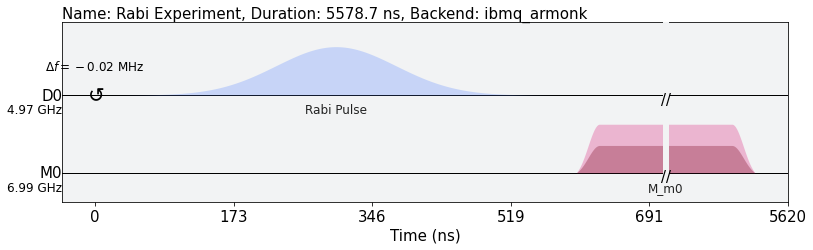

In [28]:
rabi_schedules[-1].draw(backend=real_backend)

#### Some comments on the pulse schedule:
We can see that at the very beginning that small turning arrow indicates a change in frequency which corresponds to a shift in frequency by -0.02 MHz, that is the result of the calibration we did with the frequency sweep and that is the tunning needed to update our qubit frequency from the machine default of 4.9715892 GHz to 4.9715717 GHz.

#### VI.ii. Running the series of pulse Schedules for the  Rabi experiments on qubit[0] of the ibmq_armonc machine

In [29]:

num_shots_per_point = 1024

job = real_backend.run(rabi_schedules, 
                  meas_level=1, 
                  meas_return='avg', 
                  shots=num_shots_per_point)

job_monitor(job)

Job Status: job has successfully run


In [30]:
rabi_results = job.result(timeout=120)

In [31]:
"""The tutorial suggests this function for centering the plot around zero
This seems very convenient since the Rabi signals measured will oacillate like a sine wave"""
def baseline_remove(values):
    return np.array(values) - np.mean(values)

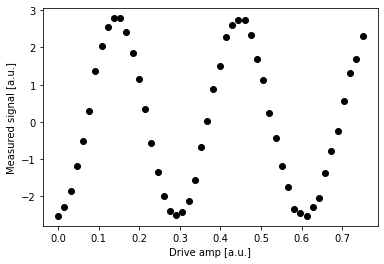

In [32]:
'''Similar to the frequency sweep we again set up an empty list for the redout signals
corresponding to the amplitudes and calling them rabi_values'''

rabi_values = []
for i in range(num_rabi_points):
    ## Get the results from the ith experiment which ran at 
    #the ith amplitude in the drive_amps list##
    rabi_values.append(rabi_results.get_memory(i)[qubit] * scale_factor)
    ## access the results for the qubit number `qubit` from this experiment, 
    #in this case its only qubit 0 since we are running a single qubit experiment##
    
##Finally we center the values vertically around zero using the baseline_remove function
rabi_values = np.real(baseline_remove(rabi_values))

plt.xlabel("Drive amp [a.u.]")
plt.ylabel("Measured signal [a.u.]")
plt.scatter(drive_amps, rabi_values, color='black') # plot real part of Rabi values
plt.show()

#### V.iii.b: Using Scipi to find the best fit for the amplitude sweep results of the Rabi Experiments

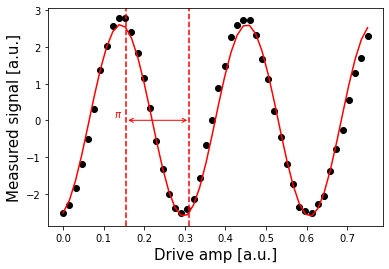

In [33]:
"""This again follows the same steps as with the frequecy sweep
However this time we use a Trignometric function for the fit instead of a Lorentzian
This requires we specify parameters:

drive_amps - the amplitudes put on the x axis
rabi_values - the readout signal on the y-axis
x - the independent variable for the anonymous function lambda
A - the amplitude of the cosine wave
B - the vertical shift
drive_period - the period of the coisne function and that
corresponds to the duration of one pulse in the series of experiments
"""
rabi_fit_params, rabi_y_fit = fit_function(drive_amps,
                                 rabi_values, 
                                 lambda x, A, B, drive_period, 
                                           phi: (A*np.cos(2*np.pi*x/drive_period - phi) + B),
                                 [3, 0.1, 0.3, 0])

plt.scatter(drive_amps, rabi_values, color='black')
plt.plot(drive_amps, rabi_y_fit, color='red')

drive_period = rabi_fit_params[2] # get period of rabi oscillation

###############################################################################################
'''The plots as they were presented in the tutorial'''

plt.axvline(drive_period/2, color='red', linestyle='--')
plt.axvline(drive_period, color='red', linestyle='--')
plt.annotate("", xy=(drive_period, 0), xytext=(drive_period/2,0), 
             arrowprops=dict(arrowstyle="<->", color='red'))
plt.annotate("$\pi$", xy=(drive_period/2-0.03, 0.1), color='red')

plt.xlabel("Drive amp [a.u.]", fontsize=15)
plt.ylabel("Measured signal [a.u.]", fontsize=15)
plt.show()

In [34]:
"""Our final calibrated amplitude for qubit[0] and the pi pulse is: """
pi_amp = abs(drive_period / 2)
print(f"Pi Amplitude = {pi_amp}")

Pi Amplitude = 0.15530724946080746


Finally we have our clibrated $\pi$ Pulse frequency and amplitudes for qubit[0]. 
Careful that this calibration is only for this specific target qubit and for this series of pulses and different qubits running different operations that need different pulses would require re-calibration on a case-by case basis.